# Project Title

**Authors:** Student 1, Student 2, Student 3
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Code import func, viz
%matplotlib inline

In [2]:
movies_df = pd.read_csv('Data/movies.csv')
ratings_df = pd.read_csv('Data/ratings.csv')
func.get_names(links_df, movies_df, ratings_df, tags_df)

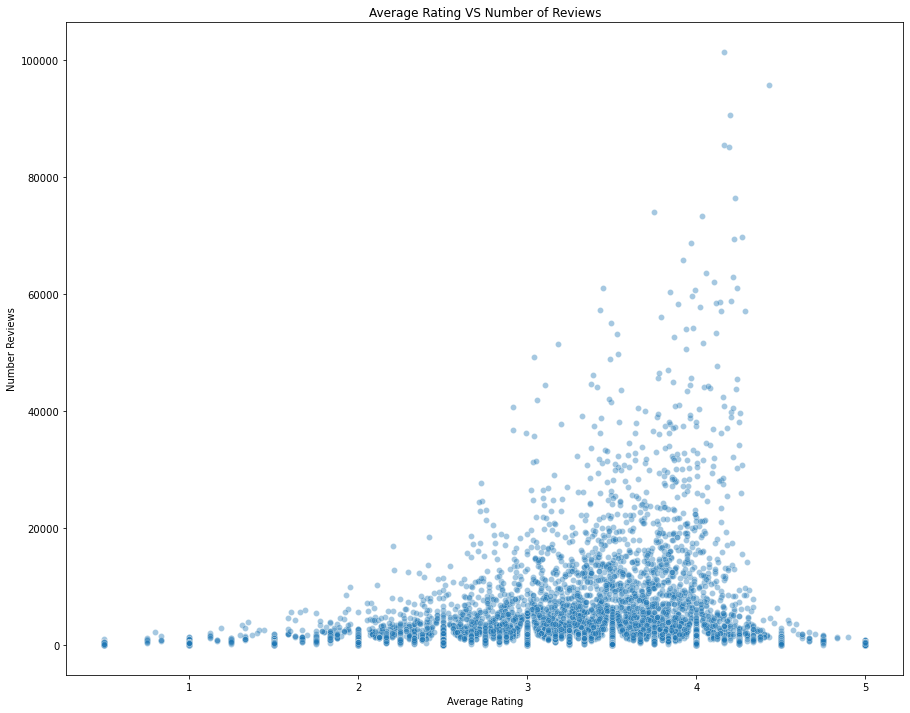

In [3]:
viz.viz_1()

In [20]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale = 1)
sns.kdeplot(ratings['rating'].fillna(ratings['rating'].median()))

NameError: name 'ratings' is not defined

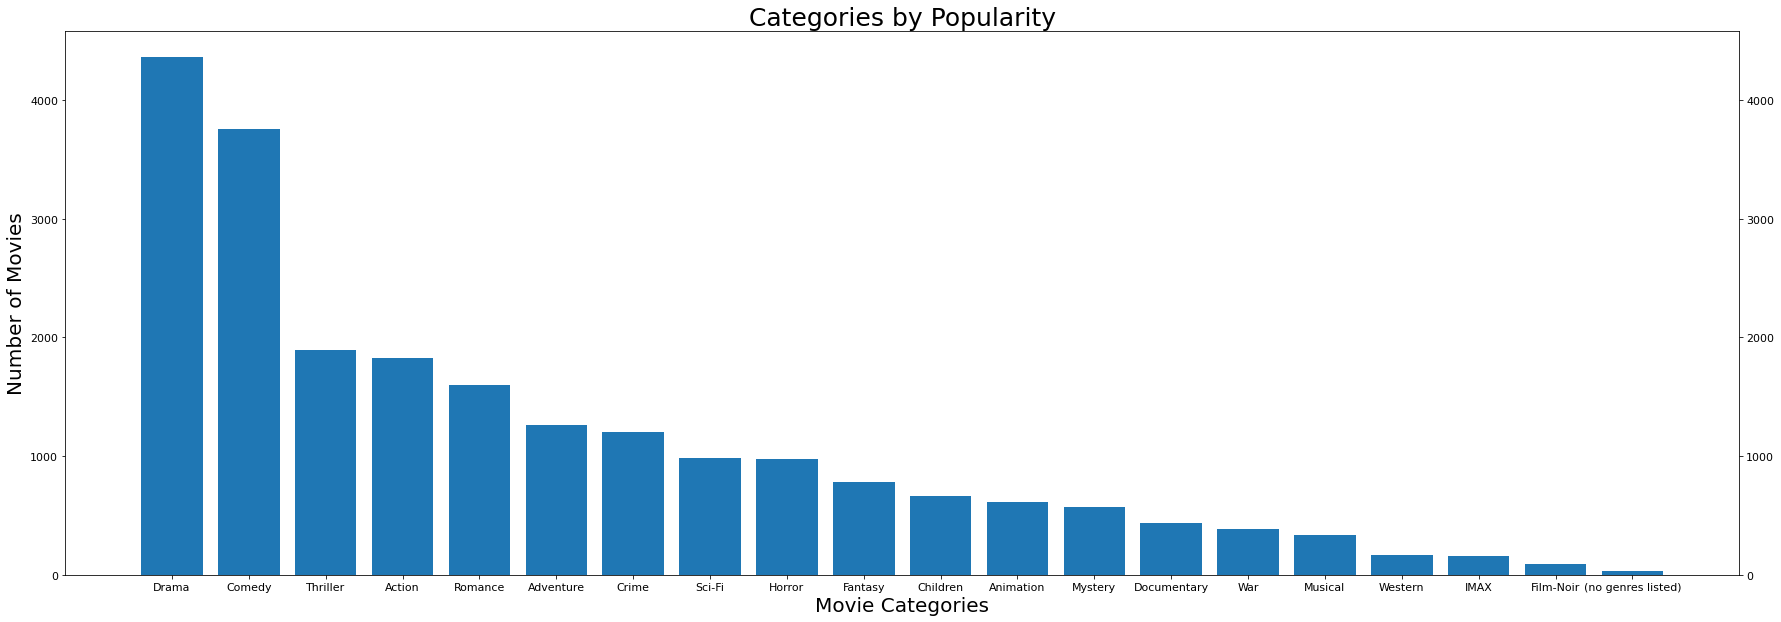

In [4]:
viz.viz_2()

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [5]:
for df in df_list:
    print(df.__dfname__)
    display(df.head(2))

links_df


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


movies_df


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


ratings_df


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


tags_df


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


In [6]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [7]:
links_df.dropna(inplace=True);

In [8]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [9]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [10]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

## SVD with Surprise

In [14]:
# Import necessary modules
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline

In [15]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['movieId', 'userId', 'rating']], reader)
dataset = data.build_full_trainset()

NameError: name 'ratings' is not defined

In [ ]:
#need to add more to the grid search later
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

print(g_s_svd.best_score)
print(g_s_svd.best_params)

## KNearest Neighbors

In [16]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

NameError: name 'data' is not defined

In [ ]:
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

In [ ]:
svd = SVD(n_factors= 50, reg_all=0.05)
svd.fit(dataset)
svd.predict(2, 4)

In [ ]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list      

In [ ]:
df_joined.drop(['userId', 'timestamp','rating'], axis=1)

In [ ]:
user_rating = movie_rater(df_joined, 3, 'Action')

In [ ]:
user_rating

In [ ]:
new_ratings_df = df_new.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [ ]:
svd_ = SVD(n_factors= 50, reg_all=0.05)
svd_.fit(new_data.build_full_trainset())

In [ ]:
list_of_movies = []
for m_id in df_new['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))

In [ ]:
list_of_movies.head()

In [ ]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [ ]:
ranked_movies.head()

In [ ]:
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,4)

## Content based Filtering

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

In [ ]:
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(movies['genres'])
cosine_score = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)

In [ ]:
#using TF-IDF Vectorizer Oject to calculate recommendations
def get_recommendations_based_on_genres(movie_title, cosine_score=cosine_score):
    """
    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = movies.loc[movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_score[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[0:4]
    
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return movies['title'].iloc[movie_indices]
    
    
#     movie_indices = [movies['title'].iloc[i[0]] for i in sim_scores_movies if movies['title'].iloc[i[0]]!=movie_title ]
    
#     # Return the top 2 most similar movies
#     print(movie_indices)

In [ ]:
#robocop why does it recommend robots
get_recommendations_based_on_genres('Steamboat Willie (1928)')

In [ ]:
movies

In [ ]:
def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = ratings[ratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
      
        movie_list.append((movies["title"][row["movieId"]==movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)
get_recommendation_content_model(2)

In [ ]:
movies

## Item-Item Filtering

In [ ]:
df_movies_ratings=pd.merge(movies, ratings)
ratings_matrix_items = df_movies_ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )

In [ ]:
ratings_matrix_items

In [ ]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items

In [ ]:

#function where returns similar movies based on item to item:

def item_similarity(movieName): 
    """
    recomendates similar movies
   :param data: name of the movie 
   """
    try:
        #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
        user_inp=movieName
        inp=movies[movies['title']==user_inp].index.tolist()
        inp=inp[0]

        movies['similarity'] = ratings_matrix_items.iloc[inp]
        movies.columns = ['movieId', 'title', 'genre','similarity']
    except:
        print("Sorry, the movie is not in the database!")

In [ ]:
item_similarity('Jungle Book, The (1967)')

In [ ]:
df_joined.loc[df_joined.userId == 54]

In [ ]:
def recommendedMoviesAsperItemSimilarity(user_id):
    """
     Recommending movie which user hasn't watched as per Item Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    
    try:
        user_movie= df_movies_ratings[(df_movies_ratings.userId==user_id) & df_movies_ratings.rating.isin(range(4,5))][['title']]
        user_movie=user_movie.iloc[0,0]

        item_similarity(user_movie)

        sorted_movies_as_per_userChoice=movies.sort_values( ["similarity"], ascending = False )
        sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
        recommended_movies=list()
        df_recommended_item=pd.DataFrame()
        user2Movies= ratings[ratings['userId']== user_id]['movieId']
        for movieId in sorted_movies_as_per_userChoice:
                if movieId not in user2Movies:
                    d=[]

                    df_new= ratings[(ratings.movieId==movieId)]
                    df_recommended_item=pd.concat([df_recommended_item,df_new])
                    best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:25] 
                    d= set(best10['movieId'].tolist())


        return d
    
    
    #recommend based on disliked movies if the selected user does not have a 4 or above rated movie
    except:
        print("this user does not have a movie she has rated above 4 to start the recommendation")
        user_movie= df_movies_ratings[(df_movies_ratings.userId==user_id) & df_movies_ratings.rating.isin(range(0,3))][['title']]
        user_movie=user_movie.iloc[0,0]

        item_similarity(user_movie)

        sorted_movies_as_per_userChoice=movies.sort_values( ["similarity"], ascending = True )
        sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] < 0.1]['movieId']
        recommended_movies=list()
        df_recommended_item=pd.DataFrame()
        user2Movies= ratings[ratings['userId']== user_id]['movieId']
        for movieId in sorted_movies_as_per_userChoice:
                if movieId not in user2Movies:
                    d=[]

                    df_new= ratings[(ratings.movieId==movieId)]
                    df_recommended_item=pd.concat([df_recommended_item,df_new])
                    best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
                    d= set(best10['movieId'].tolist())


        return d

In [ ]:
recommendedMoviesAsperItemSimilarity(54)

In [ ]:
def movieIdToTitle(listMovieIDs):
    """
     Converting movieId to titles
    :param user_id: List of movies
    :return: movie titles
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(movies[movies['movieId']==id]['title'])
    return movie_titles

In [ ]:
movieIdToTitle(recommendedMoviesAsperItemSimilarity(54))

In [ ]:
movies

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

svd = SVD()
trainset = data.build_full_trainset()
svd.fit(trainset)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
#implementing multiple recommendaiton systems together

def hybrid_model(user_id= None, new_user=False):
    
    """user_id: The id of the user that you would like to make recommendations for
    
       new_user: if you are a new user input True for this parameter.
                 Our function will then ask you for a genre and give you movies from that genre for you to rate.
                 This addresses the cold start problem
    """
    
    if new_user:
        genre= input('name a genre of movies that you like: ')
        user_rating = movie_rater(df_joined, 4, 'Action')
        
        new_ratings_df = df_new.append(user_rating,ignore_index=True)
        new_data = Dataset.load_from_df(new_ratings_df,reader)
        
        svd_ = SVD(n_factors=200, n_epochs= 40, reg_all= 0.1)
        svd_.fit(new_data.build_full_trainset())
        
        list_of_movies = []
        
        for m_id in df_new['movieId'].unique():
            list_of_movies.append( (m_id,svd_.predict(100,m_id)[3]))
        
        ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
        
        print("\n\n")
        recommended_movies(ranked_movies, movies, 5)
        
        
    else:
        recommended_movies_by_content_model = get_recommendation_content_model(user_id)
        recommended_movies_by_content_model = movies[movies.apply(lambda movie: movie["title"] in recommended_movies_by_content_model, axis=1)]
    
    
        for key, col in recommended_movies_by_content_model.iterrows():
            predict = svd.predict(user_id, col["movieId"])
            recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est
    
    
        return recommended_movies_by_content_model.sort_values("svd_rating", ascending=False).iloc[0:11]

In [ ]:
hybrid_model(33)

In [3]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
from sklearn.metrics import pairwise_distances
import numpy as np

In [5]:
ratings_matrix_users = df_movies_ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225


In [6]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()
df_similar_user.columns=['similarUser']
df_similar_user.head()

,similarUser
0,265
1,365
2,312
3,390
4,469


In [7]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [16]:
def movieIdToTitle(listMovieIDs):
  
    """
     Converting movieId to titles
    :param user_id: List of movies
    :return: movie titles
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(df_movies[df_movies['movieId']==id]['title'])      
    
    return movie_titles

In [17]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    """
     Recommending movies which user hasn't watched as per User Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user2Movies= df_ratings[df_ratings['userId']== userId]['movieId']
    sim_user=df_similar_user.iloc[0,0]
    df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
    for movieId in df_ratings[df_ratings['userId']== sim_user]['movieId']:
        if movieId not in user2Movies:
            df_new= df_movies_ratings[(df_movies_ratings.userId==sim_user) & (df_movies_ratings.movieId==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
        best10=df_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movieId']

In [18]:
user_id=50
recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[1431    Rocky (1976)
Name: title, dtype: object, 742    African Queen, The (1951)
Name: title, dtype: object, 733    It's a Wonderful Life (1946)
Name: title, dtype: object, 939    Terminator, The (1984)
Name: title, dtype: object, 969    Back to the Future (1985)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 1057    Star Trek II: The Wrath of Khan (1982)
Name: title, dtype: object, 1059    Star Trek IV: The Voyage Home (1986)
Name: title, dtype: object, 1939    Matrix, The (1999)
Name: title, dtype: object]


## User-Item filtering

In [2]:
df_ratings=pd.read_csv('Data/ratings.csv')
df_links=pd.read_csv('Data/links.csv')
df_tags=pd.read_csv('Data/tags.csv')
df_movies=pd.read_csv('Data/movies.csv')
df_movies_ratings=pd.merge(df_movies, df_ratings)

In [3]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
from sklearn.metrics import pairwise_distances
import numpy as np

In [5]:
ratings_matrix_users = df_movies_ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225


In [6]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()
df_similar_user.columns=['similarUser']
df_similar_user.head()

,similarUser
0,265
1,365
2,312
3,390
4,469


In [7]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [16]:
def movieIdToTitle(listMovieIDs):
  
    """
     Converting movieId to titles
    :param user_id: List of movies
    :return: movie titles
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(df_movies[df_movies['movieId']==id]['title'])      
    
    return movie_titles

In [17]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    """
     Recommending movies which user hasn't watched as per User Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user2Movies= df_ratings[df_ratings['userId']== userId]['movieId']
    sim_user=df_similar_user.iloc[0,0]
    df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
    for movieId in df_ratings[df_ratings['userId']== sim_user]['movieId']:
        if movieId not in user2Movies:
            df_new= df_movies_ratings[(df_movies_ratings.userId==sim_user) & (df_movies_ratings.movieId==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
        best10=df_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movieId']

In [18]:
user_id=50
recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[1431    Rocky (1976)
Name: title, dtype: object, 742    African Queen, The (1951)
Name: title, dtype: object, 733    It's a Wonderful Life (1946)
Name: title, dtype: object, 939    Terminator, The (1984)
Name: title, dtype: object, 969    Back to the Future (1985)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 1057    Star Trek II: The Wrath of Khan (1982)
Name: title, dtype: object, 1059    Star Trek IV: The Voyage Home (1986)
Name: title, dtype: object, 1939    Matrix, The (1999)
Name: title, dtype: object]


### Evaluation of Model

In [20]:
def get_user_similar_movies( user1, user2 ):
    
    """
     Returning common movies and ratings of same for both the users
    :param user1,user2: user ids of 2 users need to compare
    :return: movieIds to user 
    """
    common_movies = df_movies_ratings[df_movies_ratings.userId == user1].merge(
      df_movies_ratings[df_movies_ratings.userId == user2],
      on = "movieId",
      how = "inner" )
    common_movies.drop(['movieId','genres_x','genres_y', 'timestamp_x','timestamp_y','title_y'],axis=1,inplace=True)
    return common_movies

In [22]:
get_user_similar_movies(587,511)

,title_x,userId_x,rating_x,userId_y,rating_y
0,Forrest Gump (1994),587,4.0,511,4.5
1,Life Is Beautiful (La Vita è bella) (1997),587,5.0,511,4.5
2,"Matrix, The (1999)",587,4.0,511,5.0


## SVD ++

In [ ]:
from surprise.model_selection import train_test_split

data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.2)

In [ ]:
from surprise import SVDpp
from surprise import accuracy

In [ ]:
algo_svdpp = SVDpp(n_factors=150, n_epochs=8, lr_all=0.005, reg_all=0.1)
algo_svdpp.fit(trainset)
test_pred = algo_svdpp.test(testset)
print("SVDpp : Test Set")
accuracy.rmse(test_pred, verbose=True)

In [ ]:
movies

In [ ]:
df_joined

In [ ]:
df_2 = df_joined.groupby('title')["userId","rating"].count()[lambda x: x> 1].sort_values(by = "rating", ascending = False)

In [ ]:
df_2 = df_joined.groupby(['title','rating']).count()["userId"][lambda x: x> 1].sort_values(ascending = False)

In [ ]:
df_2

In [ ]:
df_3=df_joined.drop('timestamp', axis=1)

In [ ]:
df_3= df_3.groupby('movieId').agg([np.size, np.mean])

In [ ]:
a= df_3['userId']['size'] ==1

In [ ]:
a.value_counts()

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***